# Check Standard CCF Results
1. Plot over DRP RVs (all and for dense days)
1. Plot against DRP RVs
1. Plot order by order time series

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import fits
import pandas as pd

import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('../')
from utils import *
from data import readCCF

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
overwrite = True

In [3]:
file_tag = 'essp'
file_tag = 'neidMask'
ccf_dir = os.path.join(solar_dir,'UniformCCFs',file_tag)

## Plot CCFs

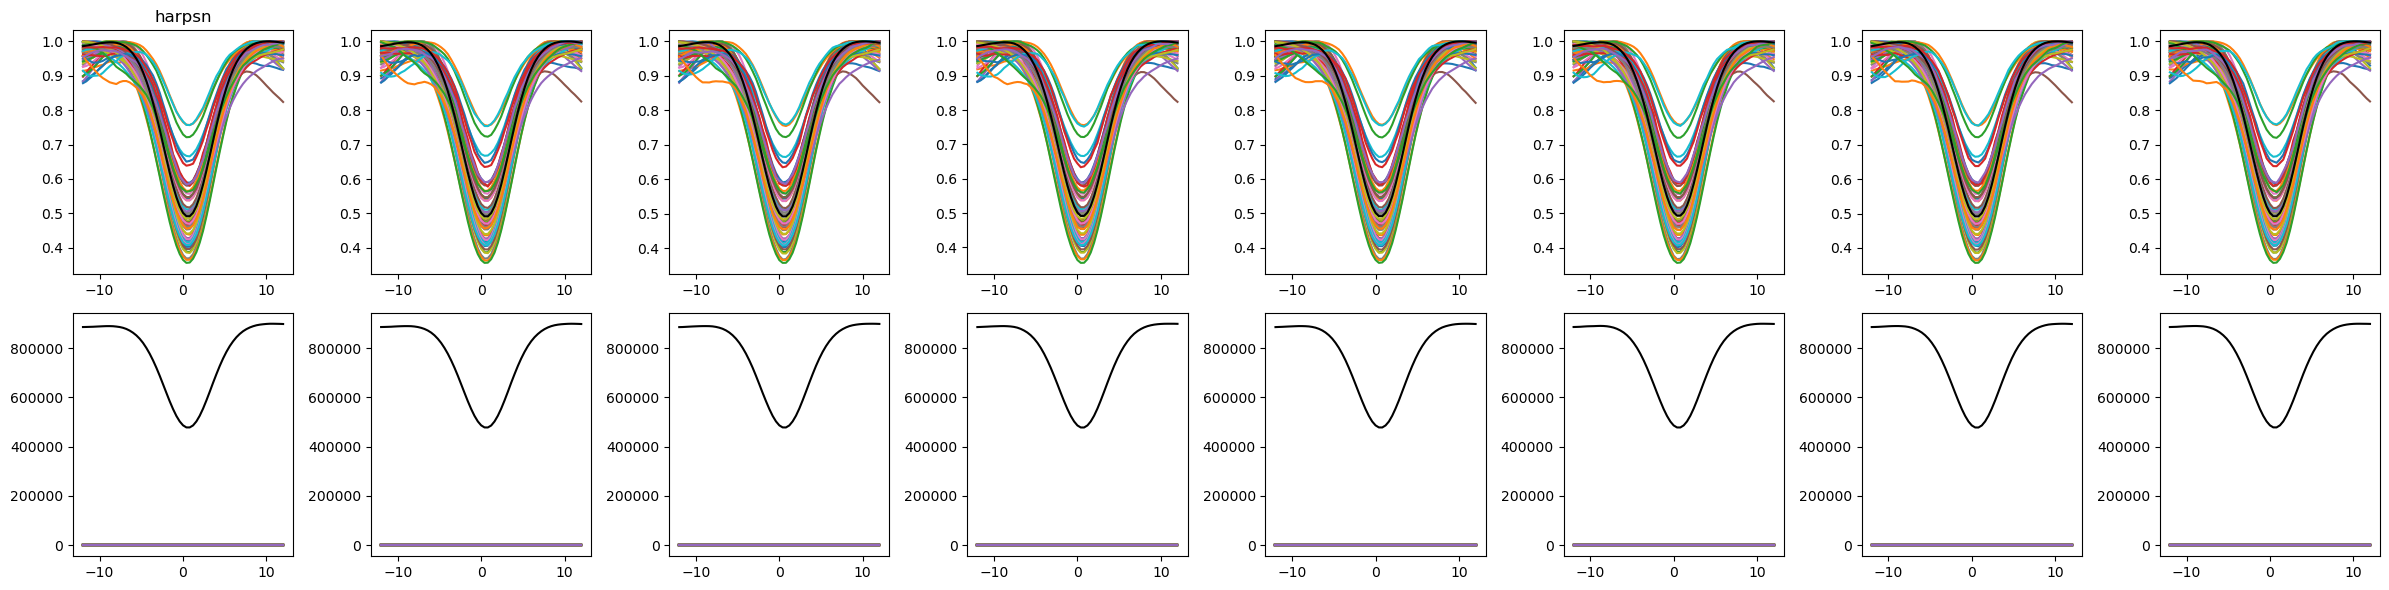

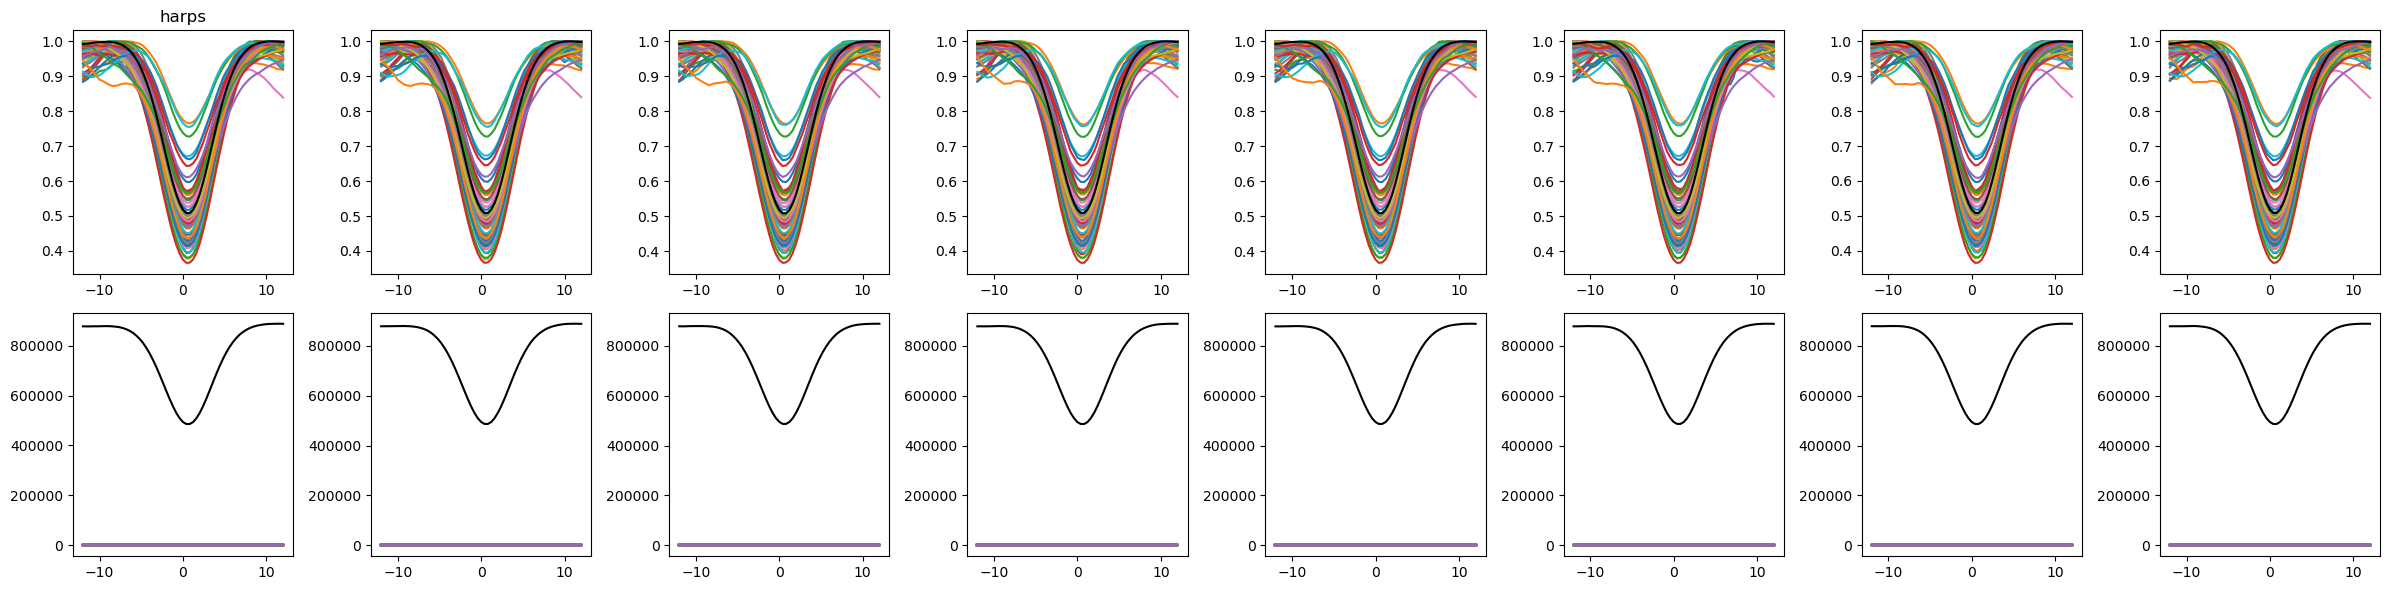

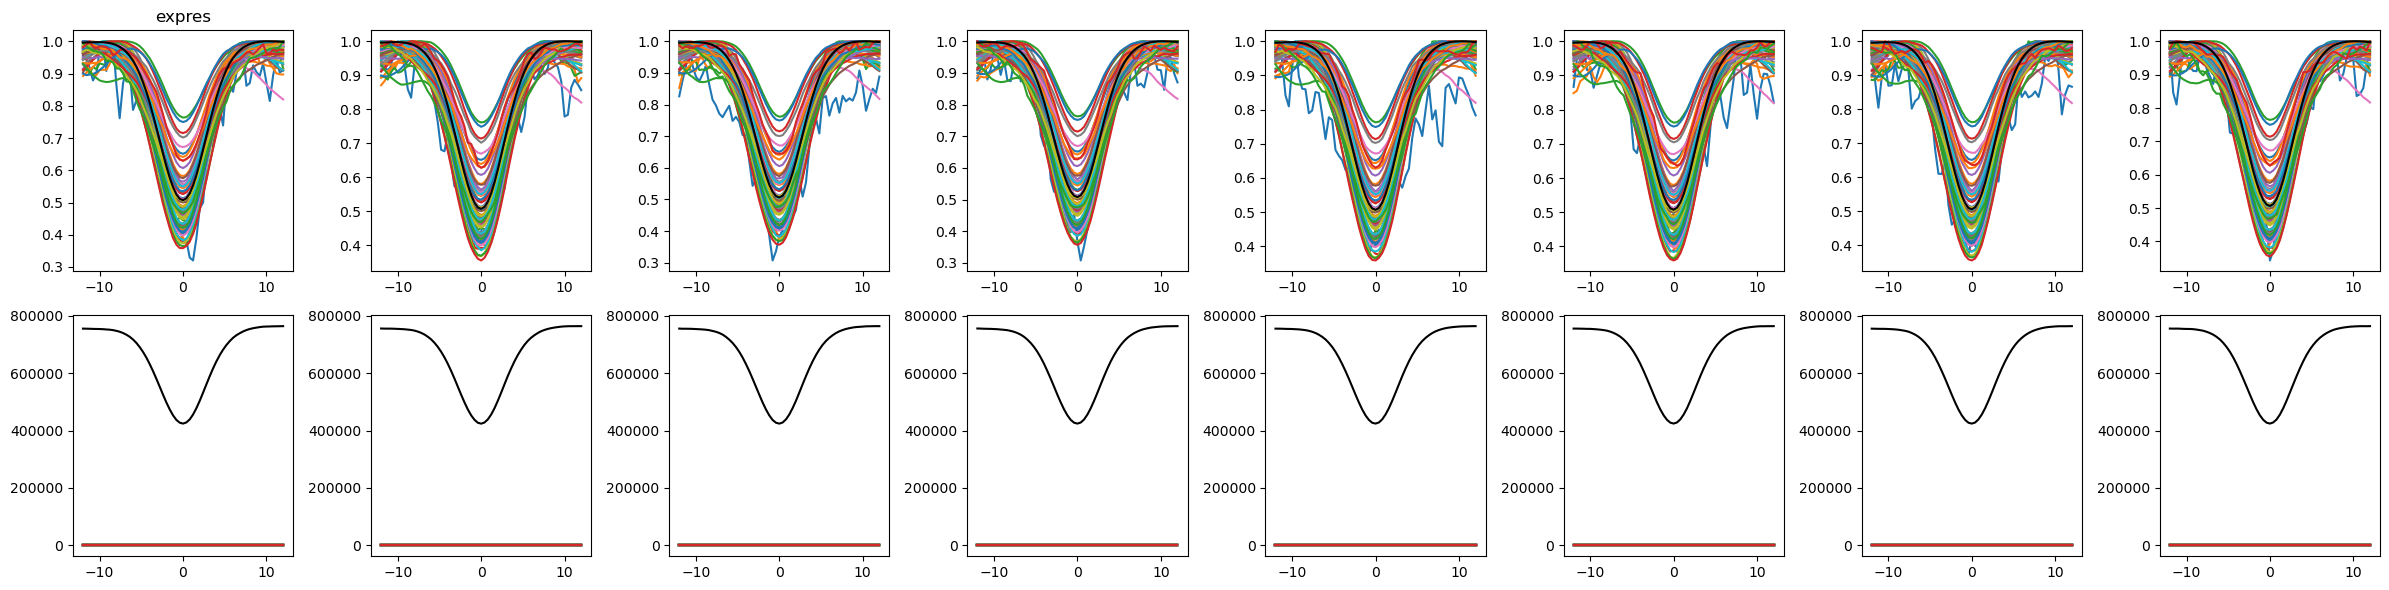

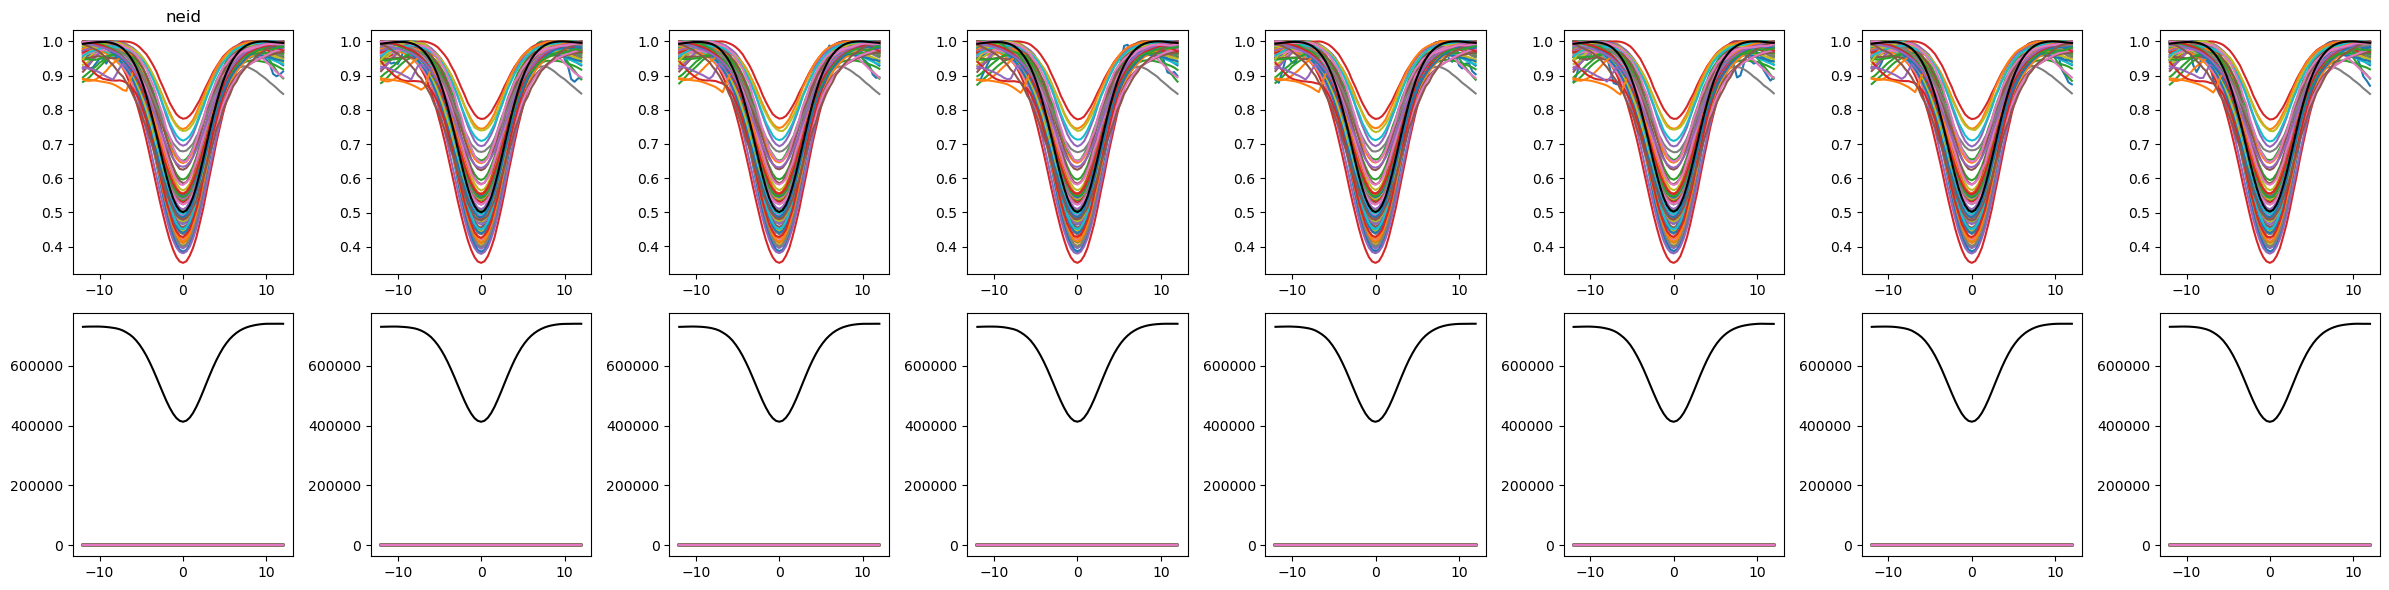

In [4]:
num_obs = 8
for iinst,inst in enumerate(instruments):
    file_list = glob(os.path.join(ccf_dir,inst,'*.fits'))
    if len(file_list)<num_obs:
        continue
    np.random.seed(len(file_list))
    fig, axes = plt.subplots(2,num_obs,figsize=(num_obs*3,2*3))
    axes[0,0].set_title(inst)
    for ifile,file in enumerate(np.random.choice(file_list,num_obs)):
        ax1, ax2 = axes[:,ifile]
        
        hdus = fits.open(file)
        num_ord = len(hdus['echelle_orders'].data)
        v_grid = hdus['v_grid'].data.copy()
        obo_ccf = hdus['obo_ccf'].data.copy()
        obo_ccf_wtd = hdus['obo_ccf_wtd'].data.copy()
        ccf = hdus['ccf'].data.copy()
        ccf_wtd = hdus['ccf_wtd'].data.copy()
        hdus.close()
        
        ord_list = np.arange(num_ord)[np.sum(np.isfinite(obo_ccf),axis=1)>0]
        for iord in ord_list:
            ax1.plot(v_grid,obo_ccf[iord]/np.nanmax(obo_ccf[iord]))
            ax2.plot(v_grid,obo_ccf_wtd[iord]/np.nanmax(obo_ccf_wtd[iord]))
        ax1.plot(v_grid,ccf/np.nanmax(ccf),'k')
        ax2.plot(v_grid,ccf_wtd,'k')
        hdus.close()
    fig.tight_layout()
    fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_ccfs_{inst}_{file_tag}.png')

## Collect CCF RVs

In [5]:
# Match File Names to DRP CCF File
def getDrpCcfFile(file_name):
    file_name = os.path.basename(file_name)
    inst = fileName2Inst(file_name)
    if inst=='neid':
        ccf_file = os.path.join(solar_dir,'NEID',file_name)
    elif inst=='expres':
        ccf_file = os.path.join(solar_dir,'CCFs_drp','EXPRES',file_name)
    else:
        inst_full = instrument_nickname2Fullname(inst)
        file_time = file_name[8:-17] if 'BLAZE' in file_name else file_name[8:-11]
        if inst=='harps':
            ccf_file = os.path.join(solar_dir,'CCFs_drp',inst_full,
                                    f'HARPS.{file_time}_ccf_G2_A.fits')
        else:
            inst_in_file = file_name.split('.')[1]
            ccf_file = os.path.join(solar_dir,'CCFs_drp',inst_full,
                                    f'r.HARPN.{file_time}_CCF_A.fits')
    # Decided to leave checking if the DRP CCF file exists to where this function is called
    return ccf_file

In [6]:
for inst in instruments:
    inst_df = pd.read_csv(os.path.join(solar_dir,f'{inst}_drp.csv')).copy()
    inst_df['essp_rv'] = np.nan
    inst_df['essp_rv_wtd'] = np.nan
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    if os.path.isfile(ccf_file) and not overwrite:
        continue
    
    num_obs = len(inst_df)
    num_ord = None
    for ifile,file in enumerate(tqdm(inst_df['File Name'],desc=inst)):
        drp_file = getDrpCcfFile(file)
        esp_file = os.path.join(ccf_dir,inst,
                                os.path.basename(file).replace('.fits','_ccf.fits'))
        if not os.path.isfile(esp_file):
            continue
        
        hdus = fits.open(esp_file)
        # Load in Global RVs
        inst_df.loc[ifile,'essp_rv'] = hdus[0].header['rv']
        inst_df.loc[ifile,'essp_rv_wtd'] = hdus[0].header['rv_wtd']
        # Load in OBO RVs
        if num_ord is None:
            num_ord = len(hdus['echelle_orders'].data)
            obo_rvs, obo_rvs_wtd = np.full((2,num_ord,num_obs),np.nan)
        obo_rvs[:,ifile] = hdus['obo_rv'].data.copy()
        obo_rvs_wtd[:,ifile] = hdus['obo_rv_wtd'].data.copy()
        hdus.close()
    obo_df = pd.DataFrame(dict(zip([f'ord{iord}' for iord in range(num_ord)],obo_rvs)))
    obo_df_wtd = pd.DataFrame(dict(zip([f'ord{iord}_wtd' for iord in range(num_ord)],obo_rvs_wtd)))
    obo_df['File Name'] = inst_df['File Name']
    obo_df_wtd['File Name'] = inst_df['File Name']
    inst_df = inst_df.set_index('File Name').join(obo_df.set_index('File Name')).join(obo_df_wtd.set_index('File Name'))
    
    inst_df.to_csv(ccf_file)

neid: 100%|██████████| 3617/3617 [02:07<00:00, 28.29it/s]


In [7]:
inst_df

Time [MJD]  RV [m/s]  RV Err. [m/s]  \
File Name                                                          
neidL2_20210526T173056.fits   59360.725  0.257834       0.156148   
neidL2_20210526T173229.fits   59360.726  0.473701       0.155960   
neidL2_20210526T173402.fits   59360.727 -0.380455       0.156032   
neidL2_20210526T173535.fits   59360.728  0.554462       0.156157   
neidL2_20210526T173709.fits   59360.729  0.586827       0.156400   
...                                 ...       ...            ...   
neidL2_20210621T220504.fits   59386.915 -0.711372       0.171654   
neidL2_20210621T220637.fits   59386.917 -1.184692       0.171785   
neidL2_20210621T220810.fits   59386.918 -2.568820       0.172005   
neidL2_20210621T220944.fits   59386.919 -0.780817       0.172380   
neidL2_20210621T221117.fits   59386.920 -2.179407       0.172575   

                             Exp. Time [s]   Airmass  Quality  \
File Name                                                       
neidL2_20210526T173056.fits      54.773258  1.124735      NaN   
neidL2_20210526T173229.fits      54.849019  1.121561      NaN   
neidL2_20210526T173402.fits      54.777741  1.118445      NaN   
neidL2_20210526T173535.fits      54.812748  1.115399      NaN   
neidL2_20210526T173709.fits      54.781360  1.112378      NaN   
...                                    ...       ...      ...   
neidL2_20210621T220504.fits      54.821212  1.228610      NaN   
neidL2_20210621T220637.fits      54.839472  1.233670      NaN   
neidL2_20210621T220810.fits      54.826100  1.238844      NaN   
neidL2_20210621T220944.fits      54.806921  1.244106      NaN   
neidL2_20210621T221117.fits      54.854849  1.249478      NaN   

                             Start Time [MJD]  BERV [km/s]    essp_rv  \
File Name                                                               
neidL2_20210526T173056.fits      59360.729816          0.0 -51.246334   
neidL2_20210526T173229.fits      59360.730896          0.0 -51.515298   
neidL2_20210526T173402.fits      59360.731976          0.0 -52.358893   
neidL2_20210526T173535.fits      59360.733052          0.0 -50.827986   
neidL2_20210526T173709.fits      59360.734140          0.0 -51.089791   
...                                       ...          ...        ...   
neidL2_20210621T220504.fits      59386.920185          0.0 -52.174709   
neidL2_20210621T220637.fits      59386.921262          0.0 -52.633334   
neidL2_20210621T220810.fits      59386.922344          0.0 -53.572209   
neidL2_20210621T220944.fits      59386.923427          0.0 -52.043615   
neidL2_20210621T221117.fits      59386.924514          0.0 -53.153298   

                             essp_rv_wtd  ...   ord83_wtd   ord84_wtd  \
File Name                                 ...                           
neidL2_20210526T173056.fits   -53.249895  ... -130.418080 -142.776136   
neidL2_20210526T173229.fits   -53.660274  ... -120.477075 -146.498251   
neidL2_20210526T173402.fits   -53.695754  ... -114.714731 -150.632933   
neidL2_20210526T173535.fits   -53.337418  ... -114.108403 -146.645515   
neidL2_20210526T173709.fits   -53.301754  ... -122.242780 -157.113449   
...                                  ...  ...         ...         ...   
neidL2_20210621T220504.fits   -52.967074  ... -117.729155 -152.338650   
neidL2_20210621T220637.fits   -52.574185  ... -123.129353 -147.279907   
neidL2_20210621T220810.fits   -53.617931  ... -133.147345 -145.931770   
neidL2_20210621T220944.fits   -52.840409  ... -133.648014 -154.617985   
neidL2_20210621T221117.fits   -53.756769  ... -131.898708 -139.402284   

                              ord85_wtd  ord86_wtd  ord87_wtd  ord88_wtd  \
File Name                                                                  
neidL2_20210526T173056.fits   93.720983        NaN        NaN        NaN   
neidL2_20210526T173229.fits   85.650267        NaN        NaN        NaN   
neidL2_20210526T173402.fits   81.259558        NaN        NaN        NaN   
neidL2_20210526T17

## Plot Over DRP RVs

harpsn 1082
harpsn 0
harps 4570
harps 0
expres 1459
expres 0
neid 3617
neid 0


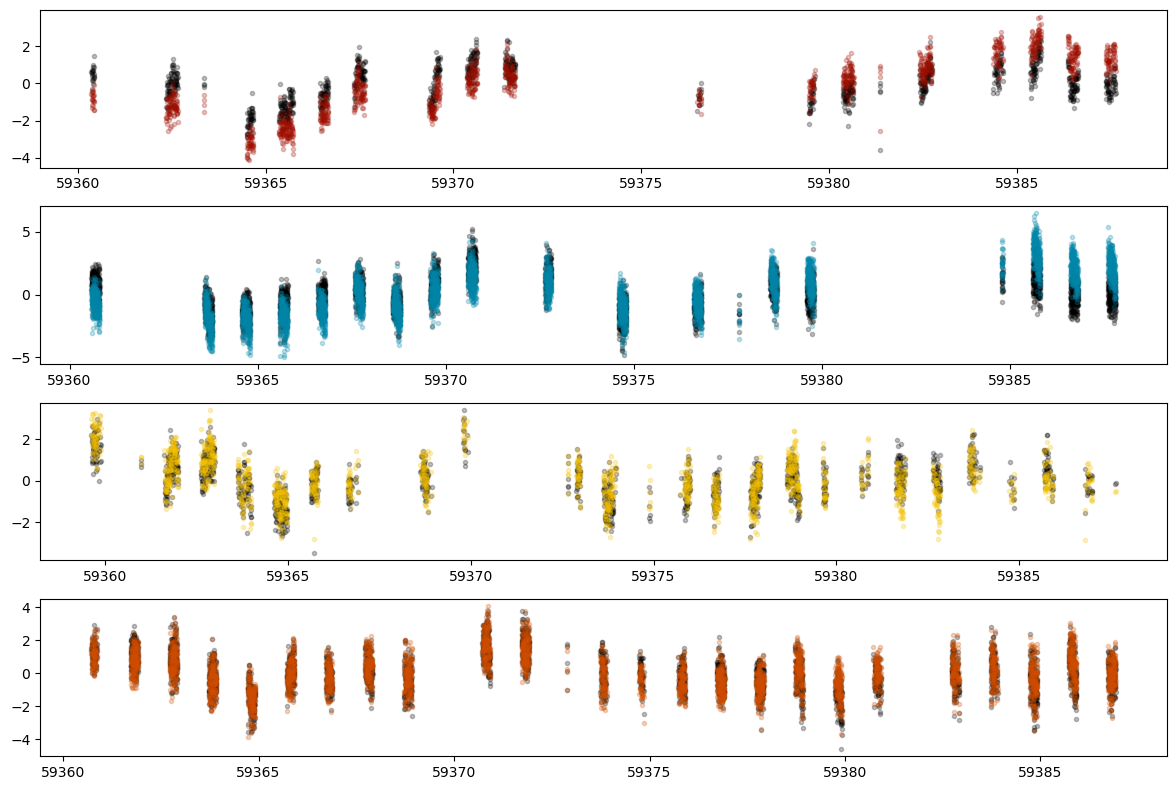

In [8]:
fig, axes = plt.subplots(4,1,figsize=(12,8))
for iinst, inst in enumerate(instruments):
    ax = axes[iinst]
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file)
    print(inst,len(ccf_df))
    ax.plot(ccf_df['Time [MJD]'],ccf_df['RV [m/s]']-np.nanmedian(ccf_df['RV [m/s]']),'.',alpha=0.25,color='k')
    ax.plot(ccf_df['Time [MJD]'],ccf_df['essp_rv']-np.nanmedian(ccf_df['essp_rv']),'.',alpha=0.25,color=inst_cols[iinst])
    print(inst,np.sum(np.isnan(ccf_df['essp_rv'])))
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_rvs_{file_tag}.png')

harpsn 0
harps 0
expres 0
neid 0


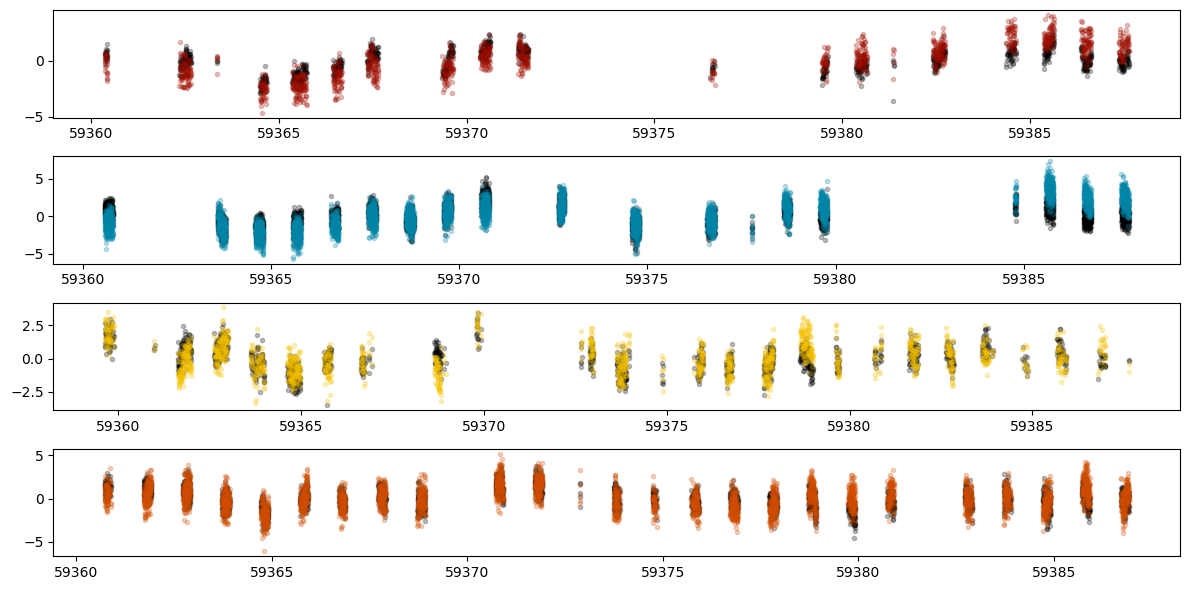

In [9]:
fig, axes = plt.subplots(4,1,figsize=(12,6))
for iinst, inst in enumerate(instruments):
    ax = axes[iinst]
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file)
    ax.plot(ccf_df['Time [MJD]'],ccf_df['RV [m/s]']-np.nanmedian(ccf_df['RV [m/s]']),'.',alpha=0.25,color='k')
    ax.plot(ccf_df['Time [MJD]'],ccf_df['essp_rv_wtd']-np.nanmedian(ccf_df['essp_rv_wtd']),'.',alpha=0.25,color=inst_cols[iinst])
    print(inst,np.sum(np.isnan(ccf_df['essp_rv_wtd'])))
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_rvswtd_{file_tag}.png')

## Plot Against DRP RVs

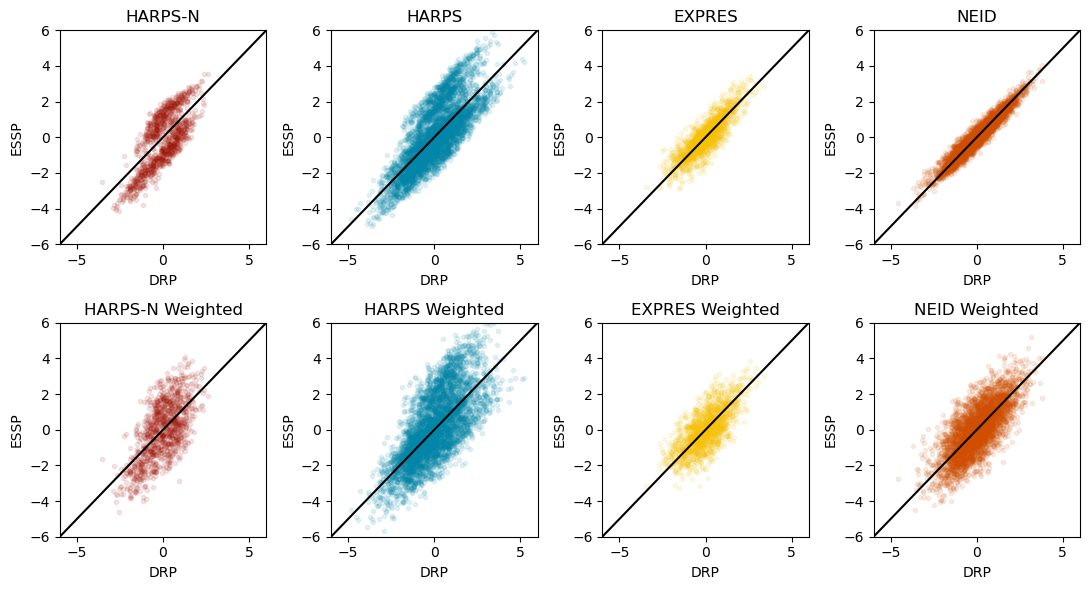

In [10]:
fig, axes = plt.subplots(2,4,figsize=(11,6))
for iinst, inst in enumerate(instruments):
    ax1, ax2 = axes[:,iinst]
    ax1.set_title(inst_names[iinst])
    ax2.set_title(inst_names[iinst]+' Weighted')
    
    # Compare RVs
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file)
    ax1.plot(ccf_df['RV [m/s]']-np.nanmedian(ccf_df['RV [m/s]']),
             ccf_df['essp_rv']-np.nanmedian(ccf_df['essp_rv']),'.',alpha=0.1,color=inst_cols[iinst])
    ax2.plot(ccf_df['RV [m/s]']-np.nanmedian(ccf_df['RV [m/s]']),
             ccf_df['essp_rv_wtd']-np.nanmedian(ccf_df['essp_rv_wtd']),'.',alpha=0.1,color=inst_cols[iinst])
    
    # Square Up
    lim = 6
    for ax in (ax1,ax2):
        ax.set_xlabel('DRP')
        ax.set_ylabel('ESSP')
        ax.plot([-lim,lim],[-lim,lim],'k')
        ax.set_xlim(-lim,lim)
        ax.set_ylim(-lim,lim)

fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_rvsVdrp_{file_tag}.png')

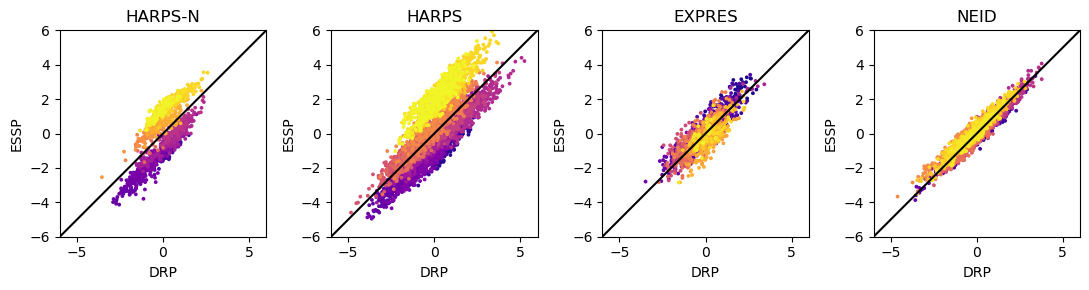

In [11]:
fig, axes = plt.subplots(1,4,figsize=(11,3))
for iinst, inst in enumerate(instruments):
    ax = axes[iinst]
    ax.set_title(inst_names[iinst])
    ax.set_xlabel('DRP')
    ax.set_ylabel('ESSP')
    
    # Compare RVs
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file)
    ax.scatter(ccf_df['RV [m/s]']-np.nanmedian(ccf_df['RV [m/s]']),
               ccf_df['essp_rv']-np.nanmedian(ccf_df['essp_rv']),
               c=ccf_df['Time [MJD]'],cmap='plasma',s=3,vmin=mon_min,vmax=mon_max)
    
    # Square Up
    lim = 6
    ax.plot([-lim,lim],[-lim,lim],'k')
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_rvsVtime_{file_tag}.png')

## Plot Order-by-Order RVs

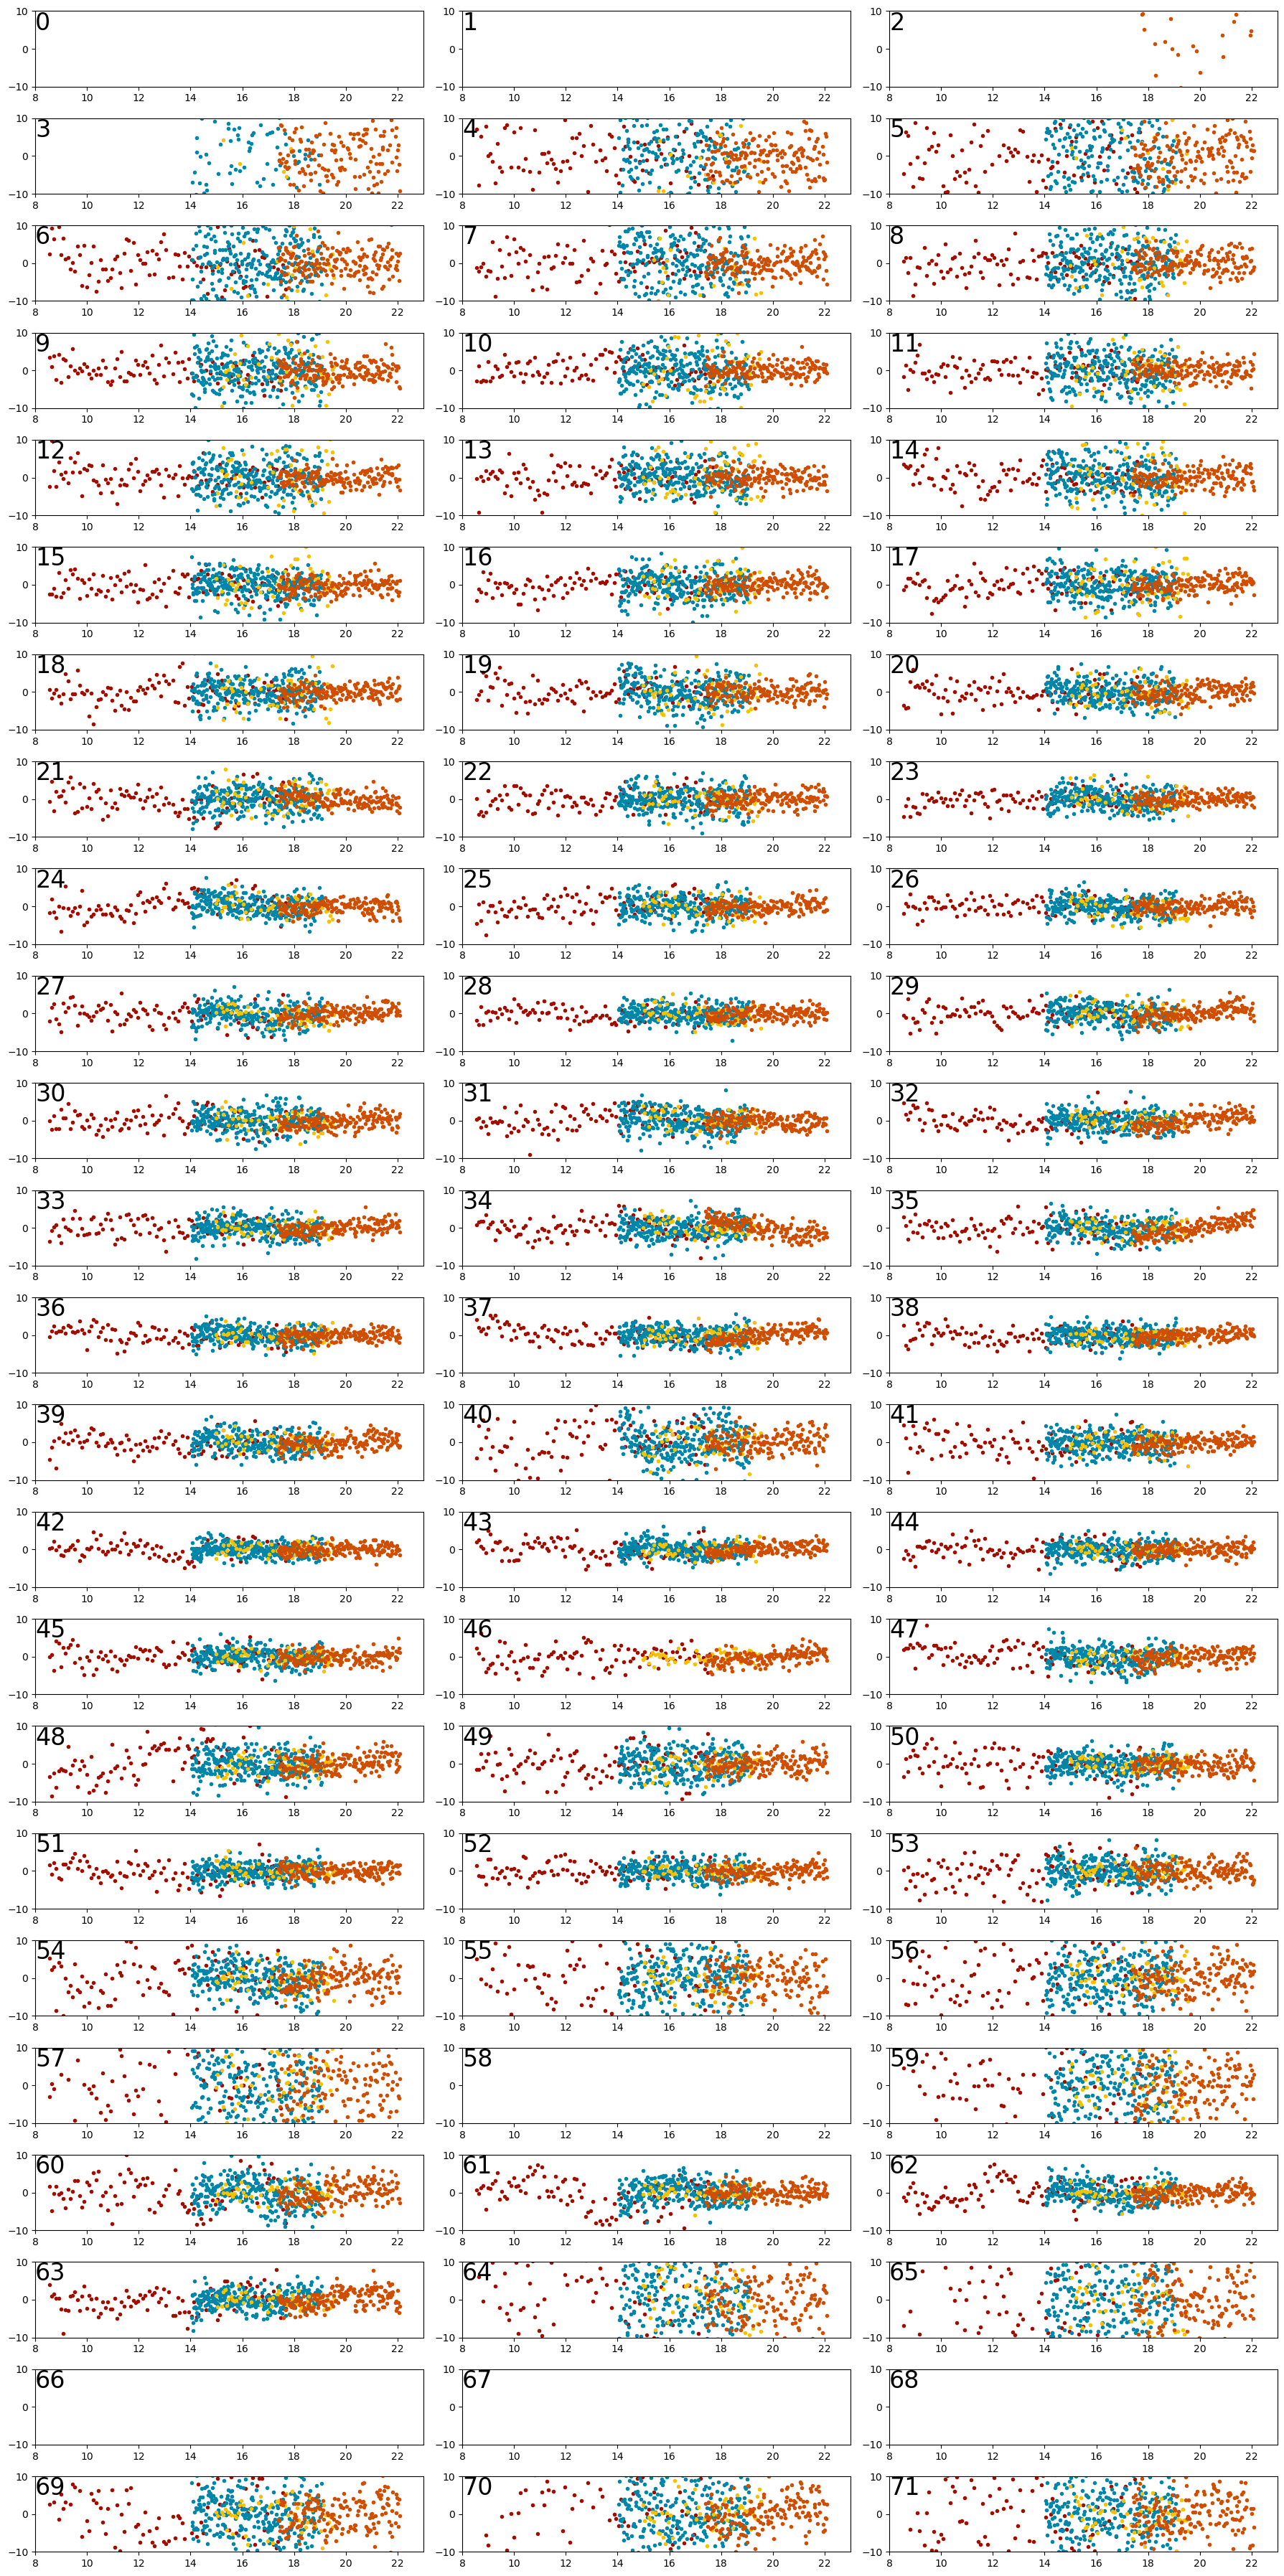

In [12]:
weighted = True
dint = int(Time('2021-05-31').mjd)
ord_list = np.arange(72)

fig, axes = plt.subplots(int(len(ord_list)//3),3,figsize=(3*6,int(len(ord_list)//3*1.5)))
axes = np.concatenate(axes)

for iinst, inst in enumerate(instruments):
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file).copy()
    dint_mask = ccf_df['Time [MJD]'].to_numpy(dtype=int)==dint
    ccf_df = ccf_df.copy()[dint_mask]
    
    # Plot Order-by-Order RVs
    time = ccf_df['Time [MJD]'].to_numpy().copy()
    time -= int(time[0])
    time *= 24
    for iord,nord in enumerate(ord_list):
        ax = axes[iord]
        if iinst==0:
            ax.text(8,10,nord,fontsize=24,ha='left',va='top')
        if f'ord{nord}' not in ccf_df.columns:
            continue
        rvel = ccf_df[f'ord{nord}'+('_wtd' if weighted else '')]
        if np.sum(np.isfinite(rvel))==0:
            continue
        rvel -= np.nanmedian(rvel)
        ax.plot(time,rvel,'.',color=inst_cols[iinst])
for ax in axes:
    ax.set_xlim(8,23)
    ax.set_ylim(-10,10)

fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut2_rvsobo_{file_tag}.png')

## Quick and Dirty Check of OBO Errors

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


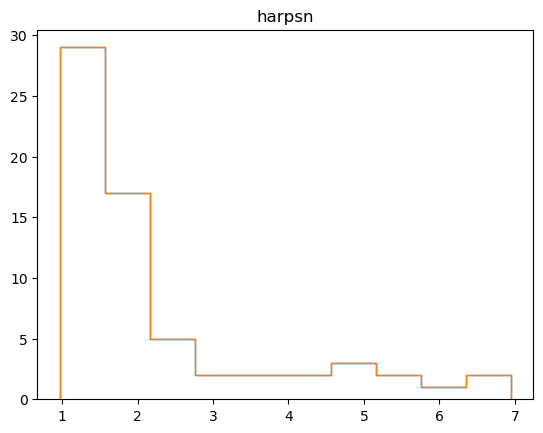

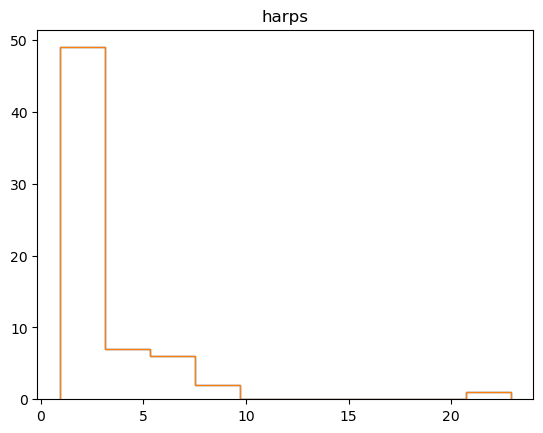

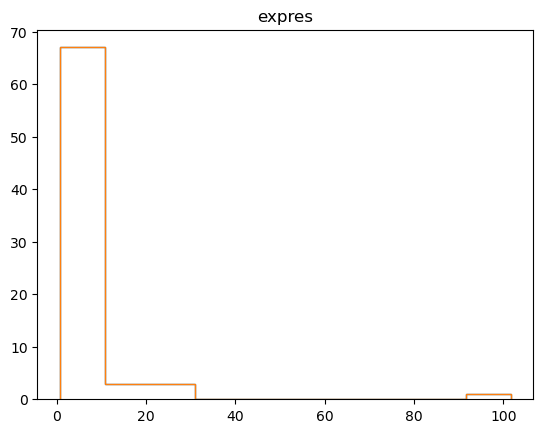

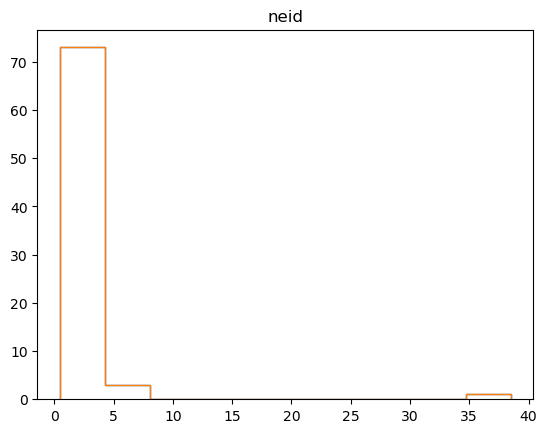

In [13]:
for iinst, inst in enumerate(instruments):
    ccf_file = os.path.join(ccf_dir,f'{inst}_ccfRVs.csv')
    ccf_df = pd.read_csv(ccf_file)
    for file in ccf_df['File Name']:
        drp_file = getDrpCcfFile(file)
        esp_file = os.path.join(ccf_dir,inst,
                                os.path.basename(file).replace('.fits','_ccf.fits'))
        if not os.path.isfile(esp_file):
            continue
        
        hdus = fits.open(esp_file)
        print(np.diff(hdus['echelle_orders'].data))
        obo_e_rv = hdus['obo_e_rv'].data.copy()
        obo_e_rv_wtd = hdus['obo_e_rv_wtd'].data.copy()
        hdus.close()
        
        plt.figure()
        plt.title(inst)
        plt.hist(obo_e_rv.flatten(),histtype='step')
        plt.hist(obo_e_rv_wtd.flatten(),histtype='step')
        break